In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import shutil


In [4]:
source_dir = '/kaggle/input/garbage-classification/garbage_classification'
target_dir = '/kaggle/working/garbage_classification'

# Remove old directory
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)

# Copy dataset
shutil.copytree(source_dir, target_dir)
print("✅ Dataset copied")

# Remove clothes class
clothes_path = os.path.join(target_dir, 'clothes')
if os.path.exists(clothes_path):
    shutil.rmtree(clothes_path)
    print("✅ Clothes class removed")


✅ Dataset copied
✅ Clothes class removed


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    target_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    target_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
NUM_CLASSES = len(class_names)

print("Classes:", class_names)


Found 8155 images belonging to 11 classes.
Found 2035 images belonging to 11 classes.
Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [7]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1769525884.510634      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769525884.511369      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,423,371 (9.24 MB)

 Trainable params: 165,387 (646.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 84s 330ms/step - accuracy: 0.9267 - loss: 0.2127 - val_accuracy: 0.8806 - val_loss: 0.3422 - learning_rate: 2.0000e-04
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 85s 335ms/step - accuracy: 0.9393 - loss: 0.1910 - val_accuracy: 0.8880 - val_loss: 0.3293 - learning_rate: 2.0000e-04
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 84s 329ms/step - accuracy: 0.9438 - loss: 0.1740 - val_accuracy: 0.8958 - val_loss: 0.3190 - learning_rate: 2.0000e-04
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 86s 337ms/step - accuracy: 0.9480 - loss: 0.1648 - val_accuracy: 0.8924 - val_loss: 0.3341 - learning_rate: 2.0000e-04
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 84s 329ms/step - accuracy: 0.9484 - loss: 0.1606 - val_accuracy: 0.8929 - val_loss: 0.3266 - learning_rate: 2.0000e-04
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 86s 335ms/step - accuracy: 0.9493 - loss: 0.1491 - val_accuracy: 0.8968 - val_loss: 0.3176 - learning_rate: 4.0000e-05
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 83s 32

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


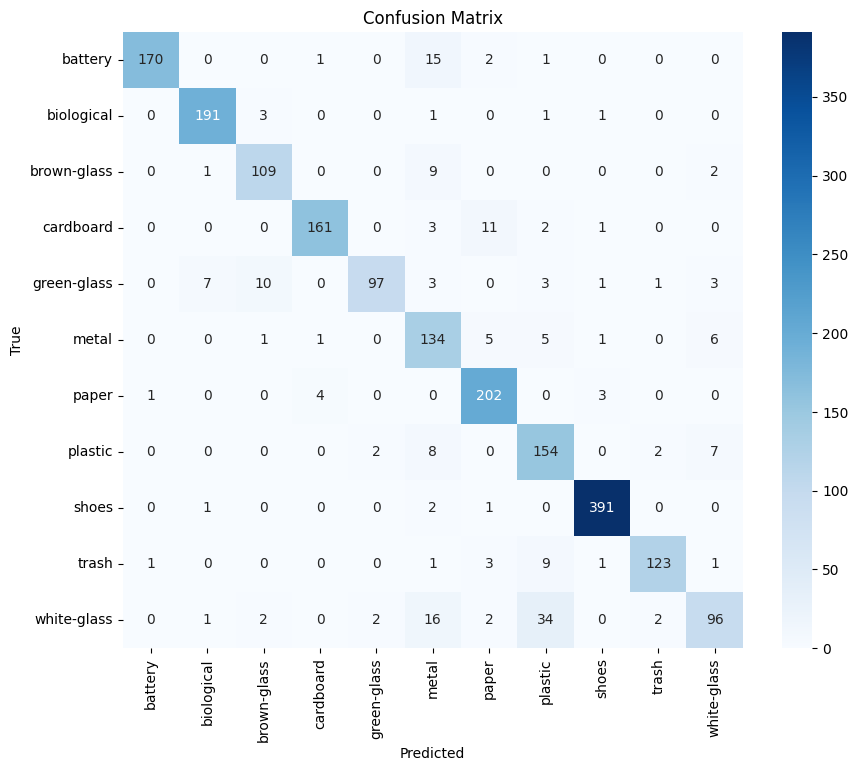


📋 Classification Report:

              precision    recall  f1-score   support

     battery       0.99      0.90      0.94       189
  biological       0.95      0.97      0.96       197
 brown-glass       0.87      0.90      0.89       121
   cardboard       0.96      0.90      0.93       178
 green-glass       0.96      0.78      0.86       125
       metal       0.70      0.88      0.78       153
       paper       0.89      0.96      0.93       210
     plastic       0.74      0.89      0.81       173
       shoes       0.98      0.99      0.98       395
       trash       0.96      0.88      0.92       139
 white-glass       0.83      0.62      0.71       155

    accuracy                           0.90      2035
   macro avg       0.89      0.88      0.88      2035
weighted avg       0.91      0.90      0.90      2035



In [12]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


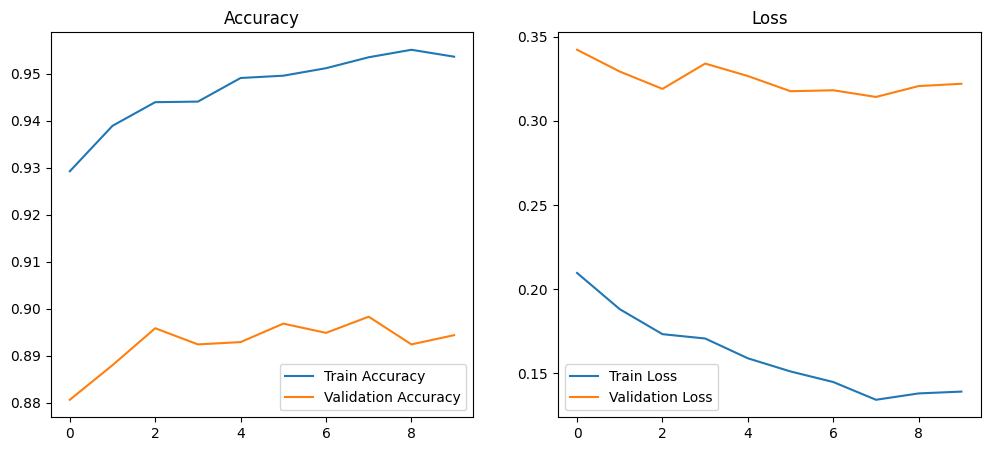

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [14]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)[0]
    idx = np.argmax(preds)

    plt.imshow(img)
    plt.title(f"Predicted: {class_names[idx]}")
    plt.axis('off')
    plt.show()

    print("Class Probabilities:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {preds[i]*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


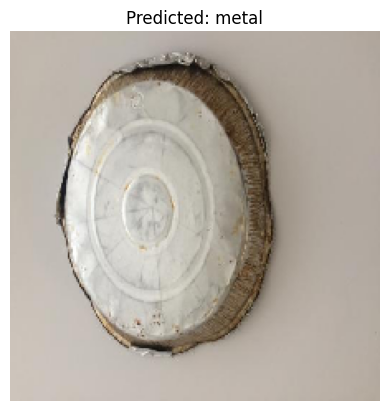

Class Probabilities:
battery: 0.00%
biological: 0.03%
brown-glass: 0.62%
cardboard: 0.02%
green-glass: 0.02%
metal: 86.00%
paper: 0.59%
plastic: 7.95%
shoes: 0.02%
trash: 0.29%
white-glass: 4.46%


In [15]:
test_img = '/kaggle/input/garbage-classification/garbage_classification/metal/metal100.jpg'
predict_image(test_img)
